# CRCD Tutorial

Thank you for having interest in CRCD! This is the official tutorial of accessing the dataset. Here, we will go through some basics usage of CRCD, including the following:

* Read the stereo endoscope calibration data
* Extract the timestamp from the videos
* Read the kinematic data
* Read the pedaldata

## Load Libraries

In [1]:
#! /usr/bin/env python3

# Import ROS libraries
import rospy
import rosbag
from sensor_msgs.msg import CameraInfo, JointState
from geometry_msgs.msg import TransformStamped

# Import basic libraries
import numpy as np
import cv2
import pickle
import random
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

# For extracting text in images
import pytesseract

## Stereo Endoscope Calibration Data

In [2]:
# Setting the camera parameters
left_endo_params = {
    # Full path to where you saved the calibration file
    "calib_path": "/home/leo/ecm_si_calib_data/30/1280x720/ECM_MONO_1280x720_L2R_calib_data_opencv.pkl",
    "cam_side"  : "left",
    # The direction of the stereo calibration.
    # If you want to have the stereo calibration based on the left camera use "L2R".
    # Otherwise, use "R2L"
    "calib_dir" : "L2R"
}

right_endo_params = {
    "calib_path": "/home/leo/ecm_si_calib_data/30/1280x720/ECM_MONO_1280x720_L2R_calib_data_opencv.pkl",
    "cam_side"  : "right",
    "calib_dir" : "L2R"
}

left_rect_endo_params = {
    "calib_path": "/home/leo/ecm_si_calib_data/30/1280x720/ECM_STEREO_1280x720_L2R_calib_data_opencv.pkl",
    "cam_side"  : "left",
    "calib_dir" : "L2R"
}

right_rect_endo_params = {
    "calib_path": "/home/leo/ecm_si_calib_data/30/1280x720/ECM_STEREO_1280x720_L2R_calib_data_opencv.pkl",
    "cam_side"  : "right",
    "calib_dir" : "L2R"
}

In [3]:
# Endoscope Camera Resolution
class Resolution():
    def __init__(self):
        self.width  = 1280
        self.height = 720

In [4]:
# Function to extract the raw camera calibration data, and save it to CameraInfo msg
# For details about CameraInfo, refer to http://docs.ros.org/en/noetic/api/sensor_msgs/html/msg/CameraInfo.html
def gen_caminfo(cam_side, calib_fn, res):
    msg = CameraInfo()
    msg.width  = res.width
    msg.height = res.height
    if "left" in cam_side:
        caminfo = "caminfoL"
    elif "right" in cam_side:
        caminfo = "caminfoR"
    with open(calib_fn, "rb") as f:
        calib_data = pickle.load(f)
    msg.distortion_model = calib_data[caminfo]["DistortionModel"]
    msg.D                = tuple(calib_data[caminfo]["D"].reshape(-1))
    msg.K                = tuple(calib_data[caminfo]["K"].reshape(-1))
    msg.R                = tuple(calib_data[caminfo]["R"].reshape(-1))
    msg.P                = tuple(calib_data[caminfo]["P"].reshape(-1))
    return msg

# However, the frames in the videos are already rectified based on the raw calibration data.
# Hence, the following function will load the stereo calibration data.
# The map_x and map_y are the output maps after rectification
# For details, refer to https://docs.opencv.org/4.8.0/d9/d0c/group__calib3d.html#ga7dfb72c9cf9780a347fbe3d1c47e5d5a
def gen_rect_caminfo(cam_side, calib_fn, caminfo_raw):
    with open(calib_fn, "rb") as f:
        calib_data = pickle.load(f)
    caminfo_rect = CameraInfo()
    caminfo_rect.width  = caminfo_raw.width
    caminfo_rect.height = caminfo_raw.height
    if "left" in cam_side:
        caminfo_rect.distortion_model = "plumb_bob"
        caminfo_rect.D                = tuple(np.zeros_like(caminfo_raw.D))
        caminfo_rect.K                = tuple(calib_data["ecm_left_rect_K"].reshape(-1))
        caminfo_rect.P                = tuple(calib_data["ecm_left_rect_P"].reshape(-1))
        map_x                         = calib_data["ecm_map_left_x"]
        map_y                         = calib_data["ecm_map_left_y"]
    elif "right" in cam_side:
        caminfo_rect.distortion_model = "plumb_bob"
        caminfo_rect.D                = tuple(np.zeros_like(caminfo_raw.D))
        caminfo_rect.K                = tuple(calib_data["ecm_right_rect_K"].reshape(-1))
        caminfo_rect.P                = tuple(calib_data["ecm_right_rect_P"].reshape(-1))
        map_x                         = calib_data["ecm_map_right_x"]
        map_y                         = calib_data["ecm_map_right_y"]
    return caminfo_rect, map_x, map_y

In [5]:
cam_res = Resolution()

left_endo_info = gen_caminfo(
    left_endo_params["cam_side"],
    left_endo_params["calib_path"],
    cam_res
)

right_endo_info = gen_caminfo(
    right_endo_params["cam_side"],
    right_endo_params["calib_path"],
    cam_res
)

left_rect_endo_info, left_map_x, left_map_y = gen_rect_caminfo(
    left_rect_endo_params["cam_side"],
    left_rect_endo_params["calib_path"],
    left_endo_info
)

right_rect_endo_info, right_map_x, right_map_y = gen_rect_caminfo(
    right_rect_endo_params["cam_side"],
    right_rect_endo_params["calib_path"],
    right_endo_info
)

## Extract Timestamp from Videos

In [6]:
# Function for extracting the time
def extract_ros_time(frame):
    # the timestamp is located on the bottom of the image
    bottom = frame[720:,:,:]
    
    # Convert the image to gray scale
    gray = cv2.cvtColor(bottom, cv2.COLOR_BGR2GRAY)
     
    # Performing OTSU threshold
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    
    # Cleaning up the threshold image
    # You can tune the size of the kernel if necessary
    kernel = np.ones((3,3),np.uint8)
    morph_close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # Return the extracted text from the image
    # It will return an empty string if not detected
    return pytesseract.image_to_string(morph_close).strip()

Random Image 21485 / 49533


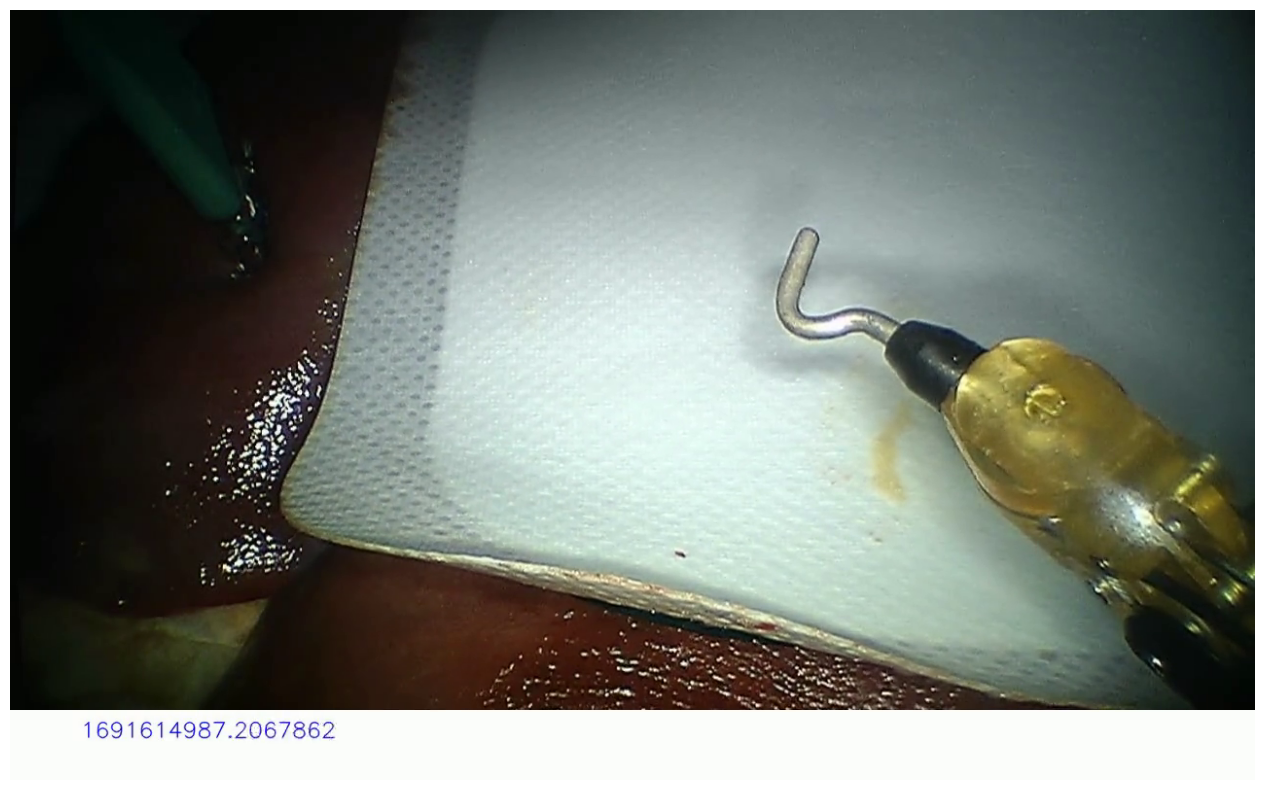

In [7]:
# An example of extracting the timestamp

# Load the video
video_path = "/home/leo/sitl_dvrk_record/left/left.mp4"
video_cap  = cv2.VideoCapture(video_path)

# Total number of frames in the video
total_frames = np.int32(video_cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Random frame index in the selected video
N = random.randint(0, total_frames)

# counter
n = 0

while video_cap.isOpened():
    ret, frame = video_cap.read()
    if ret and n < N:
        n += 1
    else:
        video_cap.release()
        break

print("Random Image {} / {}".format(N, total_frames))
plt.imshow(frame[:,:,::-1])
plt.gca().set_axis_off()

In [8]:
# Extract the ROS timestamp from the frame
rostime = extract_ros_time(frame)
print("Current ROS timestamp: {}".format(rostime))

Current ROS timestamp: 1691614987.2067862


## Reading Kinematic Data

In [21]:
# This is the dictionary containing the corresponding ROS topic name for each features mentioned in the paper.
# Abbreviations
# cp: Cartesian Pose 
# js: Joint State (joint position, velocity, effort, except for the MTM grippers)
topic_names = {
    "ecm_cp"         : "/ECM/custom/setpoint_cp",
    "ecm_local_cp"   : "/ECM/custom/local/setpoint_cp",
    "ecm_js"         : "/ECM/measured_js",
    "mtml_cp"        : "/MTML/measured_cp",
    "mtml_local_cp"  : "/MTML/local/measured_cp",
    "mtml_js"        : "/MTML/measured_js",
    "mtml_gripper_js": "/MTML/gripper/measured_js",
    "mtmr_cp"        : "/MTMR/measured_cp",
    "mtmr_local_cp"  : "/MTMR/local/measured_cp",
    "mtmr_js"        : "/MTMR/measured_js",
    "mtmr_gripper_js": "/MTMR/gripper/measured_js",
    "psm1_cp"        : "/PSM1/custom/setpoint_cp",
    "psm1_local_cp"  : "/PSM1/custom/local/setpoint_cp",
    "psm1_js"        : "/PSM1/measured_js",
    "psm1_jaw_js"    : "/PSM1/jaw/measured_js",
    "psm2_cp"        : "/PSM2/custom/setpoint_cp",
    "psm2_local_cp"  : "/PSM2/custom/local/setpoint_cp",
    "psm2_js"        : "/PSM2/measured_js",
    "psm2_jaw_js"    : "/PSM2/jaw/measured_js",
    "clutch"         : "/pedals/clutch",
    "camera"         : "/pedals/camera",
    # In some cases, the topic name of the monopolar will be
    # "monopolar"      : "/pedals/monopolar"
    "monopolar"      : "/pedals/read/monopolar"
}

In [10]:
# An example reading the PSM1 Joint State and Cartesian Pose data

# Path to kinematic rosbag
rosbag_path  = "/home/leo/sitl_dvrk_record/dvrk_kinematics.bag"

# Extracting PSM1 kinematic data
psm1_cp_msgs = []
psm1_js_msgs = []
for topic, msg, t in rosbag.Bag(rosbag_path).read_messages():
    if topic == topic_names["psm1_cp"]:
        psm1_cp_msgs.append(msg)
    elif topic == topic_names["psm1_js"]:
        psm1_js_msgs.append(msg)

In [11]:
# Let's select a random index from the list
k = random.randint(0, len(psm1_cp_msgs))

In [12]:
# Sample of the Cartesian Pose Information
# Details about this message format is described in:
# http://docs.ros.org/en/melodic/api/geometry_msgs/html/msg/TransformStamped.html
psm1_cp_msgs[k]

header: 
  seq: 79944
  stamp: 
    secs: 1691615320
    nsecs: 979943990
  frame_id: "ECM"
child_frame_id: "PSM1"
transform: 
  translation: 
    x: -0.008208607781139299
    y: 0.007461318007968454
    z: 0.06105888147760383
  rotation: 
    x: 0.34405688248295835
    y: 0.166861384035636
    z: 0.7527236346856566
    w: 0.5359004291092085

In [13]:
# The corresponding Joint State is
# Details about this message format is described in:
# http://docs.ros.org/en/melodic/api/sensor_msgs/html/msg/JointState.html
psm1_js_msgs[k]

header: 
  seq: 72925
  stamp: 
    secs: 1691615320
    nsecs: 983022831
  frame_id: ''
name: 
  - outer_yaw
  - outer_pitch
  - outer_insertion
  - outer_roll
  - outer_wrist_pitch
  - outer_wrist_yaw
position: [0.40437773876014377, -0.5710034232544118, 0.03804740779, 2.5240378497232197, 0.26346309980150096, 0.34672318005705915]
velocity: [-0.386939618994784, 0.29334448704318633, 0.020771528622661555, -1.6110381337335566, 0.2836696978869338, -0.48577472539597055]
effort: [0.08127920829322259, 0.4893700942119201, 1.1418988913133217, -0.011049984133100921, 0.02461759018758411, -0.02782654851044689]

## Reading Pedal Data

In [22]:
# An example reading the pedal data

# Path to pedal rosbag
rosbag_path  = "/home/leo/sitl_dvrk_record/dvrk_pedals.bag"

# Extracting pedal data
clutch_msgs = []
camera_msgs = []
monopolar_msgs = []
for topic, msg, t in rosbag.Bag(rosbag_path).read_messages():
    if topic == topic_names["clutch"]:
        clutch_msgs.append(msg)
    elif topic == topic_names["camera"]:
        camera_msgs.append(msg)
    elif topic == topic_names["monopolar"]:
        monopolar_msgs.append(msg)

In [15]:
# Let's select a random index from the list
m = random.randint(0, len(clutch_msgs))

In [16]:
# Sample of the Clutch Pedal data
clutch_msgs[m]

header: 
  seq: 49443
  stamp: 
    secs: 1691615001
    nsecs: 297045707
  frame_id: ''
data: False

In [18]:
# Sample of the Camera Pedal data
camera_msgs[m]

header: 
  seq: 49443
  stamp: 
    secs: 1691615001
    nsecs: 297051191
  frame_id: ''
data: False

In [23]:
# Sample of the Monopolar Pedal data
monopolar_msgs[m]

header: 
  seq: 171351
  stamp: 
    secs: 1691615001
    nsecs: 289251850
  frame_id: ''
data: False